In [1]:
# 프로그램 실행에 필요한 라이브러리 임포트

import os
import numpy as np
import tensorflow as tf
from skimage.transform import resize
import skimage.io as io
from matplotlib import pyplot as plt
import scipy
from sklearn import svm
import pickle

In [2]:
n_class = 7                # 분류 클래스의 개수
learning_rate = 0.00003    # 학습률
total_epoch = 400          # 총 epoch
batch_size = 100           # 배치사이즈
n_frame = 45               # 잘라서 가져올 frame(45로 통일)
names = ['anton', 'rimy', 'wille', 'yahwang']
classnames = ['HUM', 'LIGHT', 'OFF', 'ON', 'ONE', 'PHONE', 'TWO']
qq = [[1,0,0,0,0,0,0],[0,1,0,0,0,0,0],[0,0,1,0,0,0,0],[0,0,0,1,0,0,0],[0,0,0,0,1,0,0],[0,0,0,0,0,1,0],[0,0,0,0,0,0,1]]

In [4]:
# test 데이터 불러올 때 cnn 형식의 input으로 바꾸기 위해 사용
def make_cnn_input(res) :
    for i in range(len(res)) :
        for j in range(len(res[i])) : 
            for k in range(len(res[i][j])) :
                res[i][j][k] = [res[i][j][k]]
    res = np.asarray(res)
    res = np.transpose(res, (0,2,1,3))
    return res

In [5]:
# 피클 파일 로드
with open ('TraindataBinary.pickle', 'rb') as f :
    data = pickle.load(f)

x_data = data['x']
y_data = data['y']
print(np.asarray(x_data).shape)
print(np.asarray(y_data).shape)

(57120, 42, 45, 1)
(57120, 7)


In [6]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [7]:
# global step 정의. 시작부터 지금까지 몇번 수행했는지 알 수 있다.
global_step = tf.Variable(0, trainable=False, name="global_step")

In [8]:
# X, Y, 드롭아웃(keep_prob) 플레이스홀더 정의
X = tf.placeholder(tf.float32, [None, 42, 45, 1], name = 'X')
Y = tf.placeholder(tf.float32, [None, n_class], name = 'Y')
keep_prob = tf.placeholder(tf.float32, name = 'keep_prob')

In [9]:
# 컨볼루션 레이어 1. 42*3 크기의 커널을 50개만큼 만들겠다. 다른 설정은 보고서 참조
W1 = tf.Variable(tf.random_normal([42,3,1,50], stddev=0.01))
L1 = tf.nn.conv2d(X, W1, strides=[1,1,1,1], padding='VALID')
L1 = tf.nn.relu(L1)
L1 = tf.nn.dropout(L1, keep_prob)
print(L1.shape)

(?, 1, 43, 50)


In [10]:
# 다음 층에 입력하기 위해서 transpose라는 변칙을 살짝 사용함
#transpose(43*1*1*50 -> 43*50*1*1)
L1 = tf.transpose(L1, [0,2,3,1])
print(L1.shape)

(?, 43, 50, 1)


In [11]:
# 컨볼루션 레이어 2. 43*5 크기의 커널을 100개만큼 만들겠다. 다른 설정은 보고서 참조
W2 = tf.Variable(tf.random_normal([43,5,1,100], stddev=0.01))
L2 = tf.nn.conv2d(L1, W2, strides=[1,1,1,1], padding='VALID')
L2 = tf.nn.relu(L2)
L2 = tf.nn.dropout(L2, keep_prob)

In [12]:
# 다음 층에 입력하기 위해서 transpose라는 변칙을 살짝 사용함
#transpose(46*1*1*100 -> 46*100*1*1)
print(L2.shape)
L2 = tf.transpose(L2, [0,2,3,1])
print(L2.shape)

(?, 1, 46, 100)
(?, 46, 100, 1)


In [13]:
# Fully-Connected layer. 256개의 뉴런으로 수렴시킨다.
W3 = tf.Variable(tf.random_normal([46*100*1,256], stddev=0.01))
L3 = tf.reshape(L2, [-1, 46*100*1])
L3 = tf.matmul(L3, W3)
L3 = tf.nn.relu(L3)
L3 = tf.nn.dropout(L3, keep_prob)
print(L3.shape)
print(W3.shape)

(?, 256)
(4600, 256)


In [14]:
# 출력층. 256개의 뉴런을 출력 클래스 개수만큼 수렴시킨다. 
W4 = tf.Variable(tf.random_normal([256,n_class], stddev=0.01))
model = tf.matmul(L3,W4, name = 'model')
pred = tf.nn.softmax(model, name = 'pred')

In [15]:
# cost와 optimizer 정의. 소프트맥스 함수를 쓰고 아담 옵티마이저를 사용했다.
# logits와 labels는 shape이 같아야 한다.
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=model, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost, global_step=global_step)

In [17]:
#test data 생성
new_test_xs = []
for classname in classnames :
    for name in names :
        new_test_xs = load_data('/home/pirl/smart_switch/Test_data/%s/%s/coord/'%(name,classname), new_test_xs)
new_test_xs = make_cnn_input(new_test_xs)

print(np.asarray(new_test_xs).shape)
new_test_ys = []
for i in qq :
    for j in range(40) :
        new_test_ys.append(i)

(280, 42, 45, 1)


In [18]:
#모델 돌리기
sess = tf.Session()
saver = tf.train.Saver(tf.global_variables())
sess.run(tf.global_variables_initializer())
#ckpt = tf.train.get_checkpoint_state('./model')

total_batch = int(len(x_data)/batch_size)   # 미니배치의 총 개수

#정확도 생성
is_correct = tf.equal(tf.argmax(model, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32))

accuracylist = []

for epoch in range(total_epoch):    
    total_cost = 0
    for i in range(total_batch-1):
        batch_xs, batch_ys = x_data[(i*batch_size):((i+1)*batch_size)], y_data[(i*batch_size):((i+1)*batch_size)]   # 학습할 데이터를 배치 크기만큼 가져옴
        
        # 입력할 이미지 데이터는 batch_xs에, 출력값인 레이블 데이터는 batch_ys에 저장
        printmodel, _, cost_val = sess.run([model, optimizer, cost], feed_dict = {X: batch_xs, Y: batch_ys, keep_prob: 0.7})
        total_cost += cost_val        
        
    printaccuracy = sess.run([accuracy], feed_dict={X: new_test_xs, Y: new_test_ys, keep_prob: 1})
    print("Epoch:", "%04d"%(epoch+1), 'Avg.cost =', "{:.3f}".format(total_cost / total_batch), "Accuracy: ",printaccuracy)
    accuracylist.append(printaccuracy[0])
print("최적화 완료")

# 체크포인트 파일 생성
saver.save(sess, './model/cnn(7class).ckpt')



Epoch: 0001 Avg.cost = 1.561 Accuracy:  [0.14285715]
Epoch: 0002 Avg.cost = 1.489 Accuracy:  [0.14285715]
Epoch: 0003 Avg.cost = 1.082 Accuracy:  [0.14285715]
Epoch: 0004 Avg.cost = 0.944 Accuracy:  [0.14285715]
Epoch: 0005 Avg.cost = 0.853 Accuracy:  [0.14285715]
Epoch: 0006 Avg.cost = 0.711 Accuracy:  [0.14285715]
Epoch: 0007 Avg.cost = 0.586 Accuracy:  [0.14285715]
Epoch: 0008 Avg.cost = 0.513 Accuracy:  [0.14285715]
Epoch: 0009 Avg.cost = 0.365 Accuracy:  [0.14285715]
Epoch: 0010 Avg.cost = 0.345 Accuracy:  [0.14285715]
Epoch: 0011 Avg.cost = 0.323 Accuracy:  [0.14285715]
Epoch: 0012 Avg.cost = 0.251 Accuracy:  [0.18571429]
Epoch: 0013 Avg.cost = 0.228 Accuracy:  [0.14285715]
Epoch: 0014 Avg.cost = 0.194 Accuracy:  [0.14642857]
Epoch: 0015 Avg.cost = 0.172 Accuracy:  [0.14285715]
Epoch: 0016 Avg.cost = 0.200 Accuracy:  [0.23214285]
Epoch: 0017 Avg.cost = 0.165 Accuracy:  [0.28214285]
Epoch: 0018 Avg.cost = 0.217 Accuracy:  [0.275]
Epoch: 0019 Avg.cost = 0.223 Accuracy:  [0.27857143

In [19]:
# test data로 테스트
print("정확도:", sess.run(accuracy, feed_dict={X: new_test_xs, Y: new_test_ys, keep_prob: 1}))
print(sess.run(pred, feed_dict={X: new_test_xs, keep_prob: 1})) # test data를 쓸 때느 Dropout 확률을 1로 주어야 한다

(280, 42, 45, 1)
정확도: 0.99642855
[[1.00000000e+00 0.00000000e+00 7.43447257e-35 ... 2.96760696e-25
  1.39199115e-28 2.41589685e-26]
 [1.00000000e+00 0.00000000e+00 7.07002607e-37 ... 2.71493245e-24
  7.87074605e-29 6.50358034e-22]
 [1.00000000e+00 0.00000000e+00 2.17253161e-32 ... 6.37618423e-22
  1.21269565e-20 1.19504546e-23]
 ...
 [6.48174639e-11 1.71522088e-25 1.35556561e-14 ... 4.34290763e-11
  4.36336544e-30 1.00000000e+00]
 [3.36270223e-24 8.16212115e-27 9.51284778e-23 ... 3.59663488e-15
  2.09661448e-34 1.00000000e+00]
 [4.93124741e-16 1.34481913e-25 2.77637135e-15 ... 3.60421355e-13
  1.04613320e-31 1.00000000e+00]]


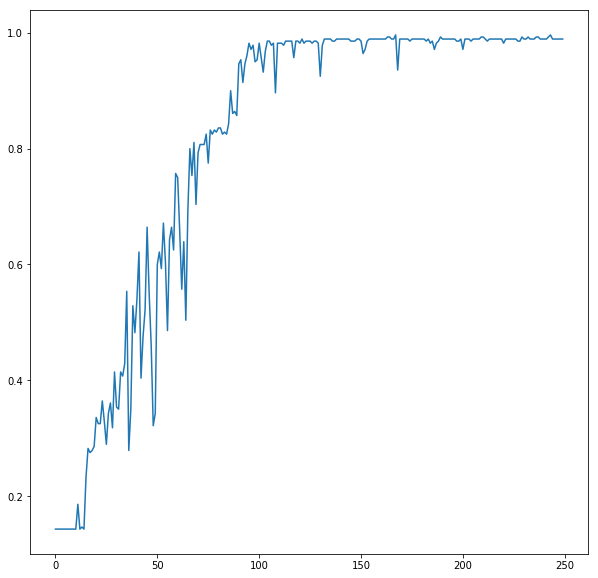

In [37]:
# 각 Batch마다 정확도가 얼마나 올라가는지를 보여준 그래프
from pylab import savefig
plt.figure(figsize=(10,10))
plt.plot(accuracylist[:250])
savefig('accuracy.png')

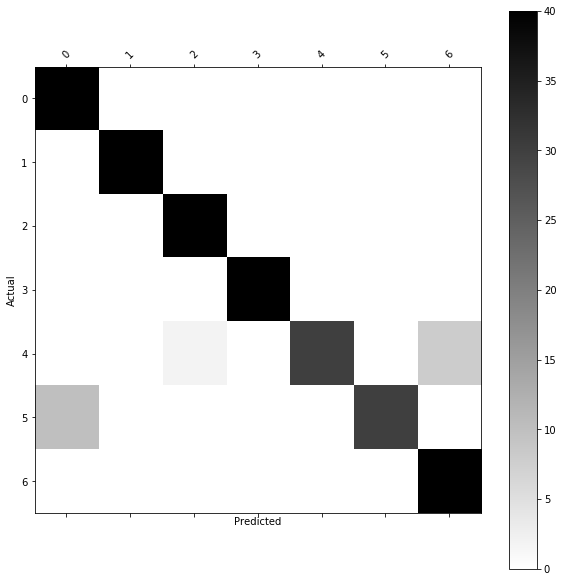

In [43]:
# test data로 혼동행렬 생성
import pandas as pd

new_test_xs2 = sess.run(pred, feed_dict={X: new_test_xs, keep_prob: 1})
new_test_xs2 = np.argmax(new_test_xs2, axis = 1)
#new_test_ys = np.argmax(new_test_ys, axis = 1)

def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap=plt.cm.gray_r):
    plt.figure(figsize=(10,10))
    plt.matshow(df_confusion, cmap=cmap, fignum = 1) # imshow
    #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    #plt.tight_layout()
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)
    savefig('confusionmatrix.png')
    
y_actu = pd.Series(new_test_ys, name='Actual')
y_pred = pd.Series(new_test_xs2, name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred)
plot_confusion_matrix(df_confusion)